In [1]:
import os
datadir = "./Move"

In [10]:
for dirpath, dirs, files in os.walk(datadir):
    #print (dirpath)
    #print (dirs)
    #print (files)
    for f in files:
        if (f.endswith(".txt")):
            print (f)

test.txt
train.txt
valid.txt


### NDSC Using CNN
reference from: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb?utm_source=practicum-IC&utm_campaign=colab-external&utm_medium=referral&hl=en&utm_content=imageexercise3-colab#scrollTo=Cj4rXshqbQlS

In [138]:
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, image
import matplotlib.pyplot as plt
import json
from pprint import pprint
from keras.models import model_from_json


In [2]:
#path = '/content/drive/My Drive/Colab Notebooks/ndsc/'
path = './Data'
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftest = pd.read_csv(os.path.join(path, 'test.csv'))

In [3]:
with open(os.path.join(path,'categories.json')) as f:
    categories = json.load(f)

pprint(categories)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
            

Swap the key and values

In [4]:
F_dict = dict((v,k.strip()) for k,v in categories['Fashion'].items())
F_dict

{23: 'Wedding Dress',
 27: 'Shirt',
 18: 'Casual Dress',
 20: 'Maxi Dress',
 24: 'Big Size Dress',
 22: 'Bodycon Dress',
 19: 'Party Dress',
 26: 'Blouse',
 25: 'Tshirt',
 29: 'Crop Top',
 28: 'Tanktop',
 17: 'Others',
 21: 'A Line Dress',
 30: 'Big Size Top'}

### 1 Feature Engineering

In [5]:
dftrain['mainCat'] = dftrain.image_path.apply(lambda x : x.split('_')[0])

In [6]:
Beautydf= dftrain[dftrain['mainCat'] == 'beauty']
Fashiondf= dftrain[dftrain['mainCat'] == 'fashion']
Mobiledf= dftrain[dftrain['mainCat'] == 'mobile']

Randomize the index

In [7]:
Beautydf = Beautydf.reindex(np.random.permutation(Beautydf.index))
Fashiondf = Fashiondf.reindex(np.random.permutation(Fashiondf.index))
Mobiledf = Mobiledf.reindex(np.random.permutation(Mobiledf.index))

In [8]:
F_X_train = Fashiondf["title"]
F_y_train = Fashiondf["Category"]

In [9]:
no_of_unique_cat  = len(np.unique(F_y_train))
no_of_unique_cat

14

#### 1.1 Check if all the images can be found

Get all the file names that are in the dataframe

In [10]:
Fashiondf['filename'] = Fashiondf.image_path.apply(lambda x : x.split("/")[1])

In [11]:
Fashiondf.head()

,itemid,title,Category,image_path,mainCat,filename
444749,1613663249,dress v neck lengan panjang model gulung berlapis,25,fashion_image/a746972a9c6b06422aa02139ee642388,fashion,a746972a9c6b06422aa02139ee642388
501498,1074236556,kaos t shirt anak lengan pendek dengan bahan k...,29,fashion_image/9d389ae479fb56cdc28d09a873c3b45f,fashion,9d389ae479fb56cdc28d09a873c3b45f
352235,1741268668,elegant ladies clothing colorful printed loose...,21,fashion_image/1a6121057378d5c368703cad3968cf9a,fashion,1a6121057378d5c368703cad3968cf9a
308988,981754293,new gamis long dress maura print hitam grosir ...,18,fashion_image/93f8184ae55e5f5d54b5dcf1b0c3afab,fashion,93f8184ae55e5f5d54b5dcf1b0c3afab
484592,1553159755,ni kaos t shirt wanita lengan panjang motif pr...,29,fashion_image/051fa7e041aa2abc614f4eb3e42a4f20,fashion,051fa7e041aa2abc614f4eb3e42a4f20


Check the distribution for each category

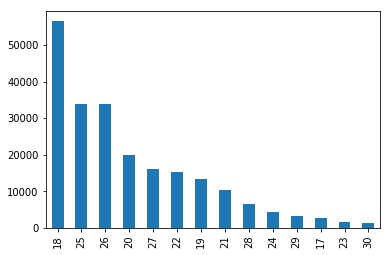

In [13]:
Fashiondf["Category"].value_counts().plot(kind='bar');

Get all the file names from the fashion directory

In [14]:
imageDir = 'C:/Users/mela_/OneDrive/2019ndsc/fashion_image'
#f_images = [f.split(".")[0] for f in listdir(imageDir) if isfile(join(imageDir, f))]

Check if all the files exists?

In [15]:
#Fashiondf[np.logical_not(Fashiondf.filename.isin(f_images))]

#### 1.2 Split into training and validation dataset

In [16]:
#X_train, X_valid, y_train, y_valid = train_test_split(Fashiondf, 
#                                    Fashiondf.Category, test_size=0.3, 
#                                                    random_state=42)

Reload the stored files from earlier session

In [17]:
X_train = pd.read_csv(os.path.join(path, 'F_X_train.csv'),
                    sep=",", index_col=0)
X_valid = pd.read_csv(os.path.join(path, 'F_X_valid.csv'),
                    sep=",", index_col=0)
y_train = pd.read_csv(os.path.join(path, 'F_y_train.csv'),
                    sep=",", index_col=0)
y_valid = pd.read_csv(os.path.join(path, 'F_y_valid.csv'),
                    sep=",", index_col=0)
X_train.head()

,itemid,title,Category,image_path,mainCat,filename
493653,1700753756,forgiveness kaos t shirt pria round neck lenga...,25,fashion_image/a398445c4e4da769468294e59883aa88,fashion,a398445c4e4da769468294e59883aa88
450858,1585853458,blus casual wanita model off shoulder lengan p...,27,fashion_image/d2feafdab23d43e527c1692a681da3a8,fashion,d2feafdab23d43e527c1692a681da3a8
384417,1025763729,women flare long sleeve loose v neck patchwork...,18,fashion_image/ed362dc6198821a68e8eba983825b533,fashion,ed362dc6198821a68e8eba983825b533
505492,1496220705,atasan blus lengan panjang v neck dengan motif...,27,fashion_image/985c95340b53752cccdc235099ebd750,fashion,985c95340b53752cccdc235099ebd750
363177,1393698784,bayar di tempat rok maxi asimetris boho vintag...,18,fashion_image/cf823af99ca10a23ef06dba1388303fa,fashion,cf823af99ca10a23ef06dba1388303fa


Check the distribution for training and validation

In [18]:
X_train["Category"].value_counts()

18    39681
26    23717
25    23673
20    13980
27    11333
22    10646
19     9401
21     7411
28     4531
24     2966
29     2364
17     1910
23     1160
30     1018
Name: Category, dtype: int64

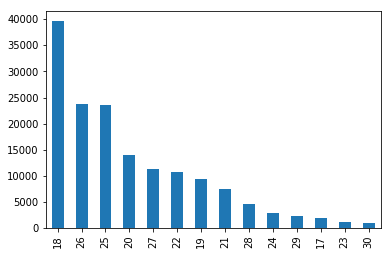

In [19]:
X_train["Category"].value_counts().plot(kind='bar');

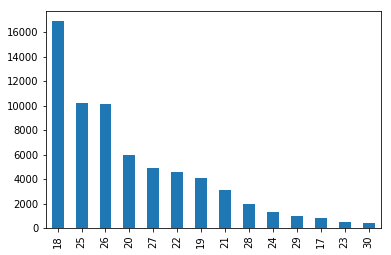

In [20]:
X_valid["Category"].value_counts().plot(kind='bar');

Move the files to train dir and validation dir

In [21]:
#X_train.head()

Create new folder to temp train the images.
Cleanup will remove these later

In [22]:
def createFolder(folderpath):
    if not os.path.exists(folderpath):
        os.mkdir(folderpath)
        print ("Created:", folderpath)

In [23]:
import shutil
def copyFiles(srcDir, destDir, df, bSilent=1, ext=".jpg"):
    for fname in df["filename"]:
        filename = fname + ext
        src = os.path.join(srcDir, filename)                        
        dst = os.path.join(destDir, filename)
        
        if os.path.exists(src):
            shutil.copyfile(src, dst)
        if (not bSilent):
            print ("Copy file {} from {} to {}".format(fname, src, dst))

def moveFiles(srcDir, destDir, df, bSilent=1, ext=".jpg"):
    for index, row in df.iterrows():
        filename = row['filename'] + ext
        
        #move to the category folder
        dstCat = os.path.join(destDir, F_dict[row["Category"]])
        createFolder(dstCat)
        
        src = os.path.join(srcDir, filename)                        
        dst = os.path.join(dstCat, filename)
        
        if os.path.exists(src):
            shutil.move(src, dst)
                
        if (not bSilent):
            print ("Move file {} from {} to {}".format(fname, src, dst))            

def cleanup(folderPath):
    shutil.rmtree(folderPath)
    print ("Deleted ", folderPath)

Create all the temp folders

In [24]:
train_dir = os.path.join(imageDir, 'train')                                
#createFolder(train_dir)

validation_dir = os.path.join(imageDir, 'validation')                      
#createFolder(validation_dir)

test_dir = os.path.join(imageDir, 'test')                                  
#createFolder(test_dir)

Copy all the temp image over

In [25]:
#copyFiles(imageDir, train_dir, X_train)

In [26]:
#copyFiles(imageDir, validation_dir, X_valid)

In [27]:
print('total training Fashion images:', len(os.listdir(train_dir)))
print('total validation Fashion images:', len(os.listdir(validation_dir)))

total training Fashion images: 14
total validation Fashion images: 14


In [28]:
#moveFiles(train_dir,train_dir, X_train)

#### 1.3 Need to create a category folder for each training / validation

In [29]:
#moveFiles(validation_dir,validation_dir, X_valid)

Save all the training and testing df because the copying takes too long

In [30]:
#X_train.to_csv(os.path.join(path, 'F_X_train.csv'))
#y_train.to_csv(os.path.join(path, 'F_y_train.csv'))
#X_valid.to_csv(os.path.join(path, 'F_X_valid.csv'))
#y_valid.to_csv(os.path.join(path, 'F_y_valid.csv'))

In [31]:
#cleanup(train_dir)
#cleanup(validation_dir)

### 2 Build a base framework

In [32]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(no_of_unique_cat, activation='softmax'))

In [33]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### 2.1 Utility to save and load the model back later

In [35]:
# serialize model to JSON
def saveModelToDisk(model, filename, path = './Data'):
    model_json = model.to_json()

    with open(os.path.join(path,"{}.json".format(filename)), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(path,"{}.h5".format(filename)))
    print("Saved model to disk")
    
#saveModelToDisk(model,"M_model{}".format(str_today))

In [36]:
def loadModelFromDisk(filename, path = './Data'):
    # load json and create model
    json_file = open(os.path.join(path,'{}.json'.format(filename)), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model = loadWeightsFromDisk(loaded_model, filename, path)
    print("Loaded model from disk")

    return loaded_model

def loadWeightsFromDisk(loaded_model, filename, path="./Data"):
    # load weights into new model
    loaded_model.load_weights(os.path.join(path,"{}.h5".format(filename)))
    print("Loaded weights from disk")
    return loaded_model

### 3 Data Preprocessing

Rescale all the images by 1/255 and resize to 150 * 150

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)             
test_datagen = ImageDataGenerator(rescale=1./255)           
batch_size = 100

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 153791 images belonging to 14 classes.
Found 65911 images belonging to 14 classes.


In [38]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 150, 150, 3)
labels batch shape: (100, 14)


In [39]:
for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 150, 150, 3)
labels batch shape: (100, 14)


#### 3.1 Start the training

In [59]:
#model = loadWeightsFromDisk(model, "Fashion_1", path="./Weight")
if True:
    history = model.fit_generator(
          train_generator,
          steps_per_epoch=batch_size,
          epochs=2,
          validation_data=validation_generator,
          validation_steps=50)

Loaded weights from disk
Epoch 1/2
100/100 [==============================] - 242s 2s/step - loss: 2.1605 - acc: 0.2747 - val_loss: 2.0725 - val_acc: 0.2956
Epoch 2/2
100/100 [==============================] - 222s 2s/step - loss: 2.1508 - acc: 0.2834 - val_loss: 2.0578 - val_acc: 0.3019


Save the model after training

In [60]:
#model.save('Fashion_1.h5')
saveModelToDisk(model, "Fashion_1", "./Weight")

Saved model to disk


#### 3.2 Plot the training accuracy and loss

In [42]:
def plotAccuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

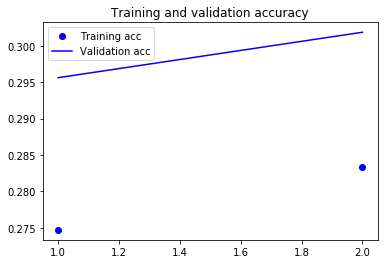

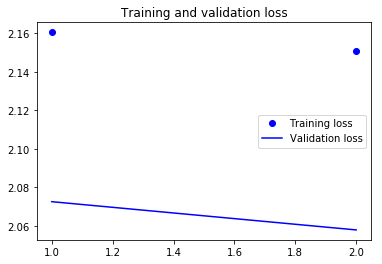

In [61]:
plotAccuracy(history)

#### 3.3 Data Augmentation

Transforming the available dataset to train with more data.

In [44]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Checking the augmented images

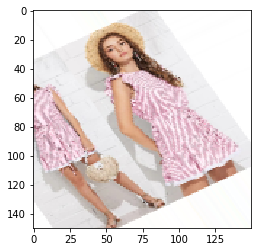

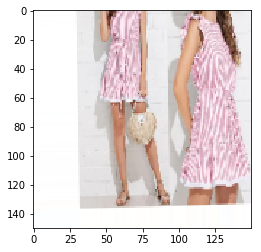

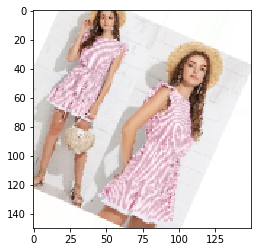

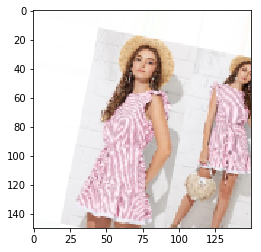

In [46]:
sampleDir = os.path.join(imageDir, "train", F_dict[18])
fnames = [os.path.join(sampleDir, fname) for
     fname in os.listdir(sampleDir)]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

#### 3.4 Adding Dropout

In [50]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(no_of_unique_cat, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

#### 3.5 Training the model with datagen

In [54]:
def setupDataGen(batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical')
    
    return train_datagen, test_datagen, train_generator, validation_generator

Found 153791 images belonging to 14 classes.
Found 65911 images belonging to 14 classes.


In [55]:
history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=batch_size,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/2
100/100 [==============================] - 240s 2s/step - loss: 2.2380 - acc: 0.2509 - val_loss: 2.2531 - val_acc: 0.2525
Epoch 2/2
100/100 [==============================] - 230s 2s/step - loss: 2.2212 - acc: 0.2589 - val_loss: 2.2134 - val_acc: 0.2394


Check the accuracy

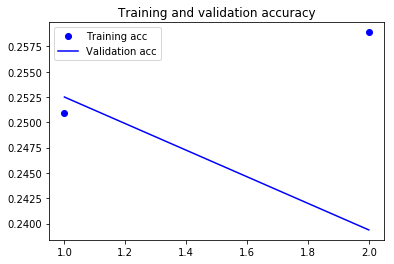

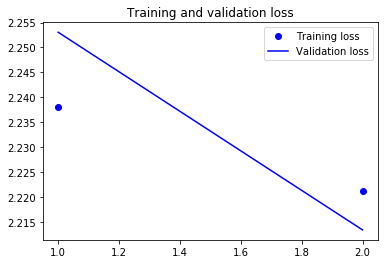

In [56]:
plotAccuracy(history2)

Save the second model

In [57]:
saveModelToDisk(model, "Fashion_2", "./Weight")

Saved model to disk


### 4.0 Using a pretrained covnet

#### 4.1 Feature extraction
Using only the conv base from the VGG16 model

In [63]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 36s 1us/step


In [144]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 4.2 without data augmentation

In [167]:
train_size = 10000
valid_size = 5000

In [168]:
#test_dir = os.path.join(imageDir, 'test')
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count, batch_size=1000):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, no_of_unique_cat))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
#test_features, test_labels = extract_features(test_dir, valid_size)

In [169]:
train_features, train_labels = extract_features(train_dir, train_size)

Found 153791 images belonging to 14 classes.


ResourceExhaustedError: OOM when allocating tensor with shape[32,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node block1_conv2/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block1_conv1/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node block5_pool/MaxPool/_459}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_127_block5_pool/MaxPool", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, valid_size)

Flatten them

In [ ]:
train_features = np.reshape(train_features, (train_size, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (valid_size, 4 * 4 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Training using these features

In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='elu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(no_of_unique_cat, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                        epsilon=None, decay=0.3, amsgrad=True),
                          #optimizers.SGD(lr=0.01, decay=1e-6, 
                         #           momentum=0.9, nesterov=True), #RMSprop(lr=2e-5)
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
batch_size2 = 100
history3 = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=batch_size2,
                    validation_data=(validation_features, validation_labels))

Check the accuracy

In [ ]:
plotAccuracy(history3)

#### 4.3 with data augmentation

In [166]:
type(layers.Flatten(conv_base))

AttributeError: 'Model' object has no attribute 'lower'

In [194]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
#x = layers.Flatten()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [186]:
#model2 = models.Sequential()
#model2.add(conv_base)
#model2.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
#model2.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(no_of_unique_cat, activation='softmax'))

#last = conv_base.output
model = Model(inputs=conv_base.input, outputs=add_model(conv_base.output))
x = layers.Flatten()(last)
x = Dense(256, activation='relu')(x)
preds = layers.Dense(no_of_unique_cat, activation='softmax')(x)
model = layers.Model(inputs=conv_base.input, outputs=preds)

AttributeError: Layer vgg16 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [195]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_577 (Conv2D)             (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, None, None, 3 96          conv2d_577[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, None, None, 3 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_578

In [ ]:
model.summary()

Freeze the representation to maintain the previous learned convnet

In [ ]:
print('This is the number of trainable weights before freezing the conv base:', 
      len(model.trainable_weights))')
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', 
      len(model.trainable_weights))

Start training the model

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

### 1.0 Using the Inception V3 Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './Weight/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Make it non trainable? Why

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print ('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

### 2.0 Training my model

In [ ]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define our example directories and files
base_dir = 'C:/Users/mela_/OneDrive/2019ndsc/fashion_image'
#train_dir = base_dir #os.path.join(base_dir, 'train')
#validation_dir = base_dir #os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_F_dir = base_dir #os.path.join(train_dir, 'cats')
valid_F_dir = base_dir

train_F_fnames = os.listdir(train_F_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_F_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')